## 1 - Load Dataset

In [38]:
from dataset import ogb_dataset_to_nx_graph

dataset_name = 'ogbn-arxiv'

graph = ogb_dataset_to_nx_graph(dataset_name)

print(graph.number_of_nodes(), graph.number_of_edges())

169343 1157799


## 2 - Sample Random Subgraph

In [15]:
import random
from tqdm import tqdm
import numpy as np
from graph import SubgraphHandler

subgraph_size = 10_000

# Get an initial subgraph node set
subgraph_nodes = list(np.random.choice(graph.nodes(), size=(subgraph_size), replace=False))

subgraph = SubgraphHandler(
    full_graph = graph, 
    initial_node_set = subgraph_nodes
)

## 3 - Metropolis-Hastings

In [23]:
num_iters = 10_000

prev_ks_dist = subgraph.ks_distance()
distance_history = []

for i in tqdm(range(num_iters)):
    # Randomly pick a node to remove and add to the subgraph
    remove_node = np.random.choice(subgraph.nodes)
    add_node = np.random.choice(subgraph.nodes_not_in_subgraph)

    subgraph.remove(remove_node)
    subgraph.add(add_node)

    # Calculate the new Degree KS Distance
    new_ks_dist = subgraph.ks_distance()

    ratio = (prev_ks_dist / new_ks_dist) ** 2000
    prop = random.random()
    if ratio > prop:
        # Accept
        prev_ks_dist = new_ks_dist
    else:
        # Reject and revert back
        subgraph.add(remove_node)
        subgraph.remove(add_node)

    distance_history.append(prev_ks_dist)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [08:37<00:00, 19.31it/s]


Text(0, 0.5, 'KS Distance')

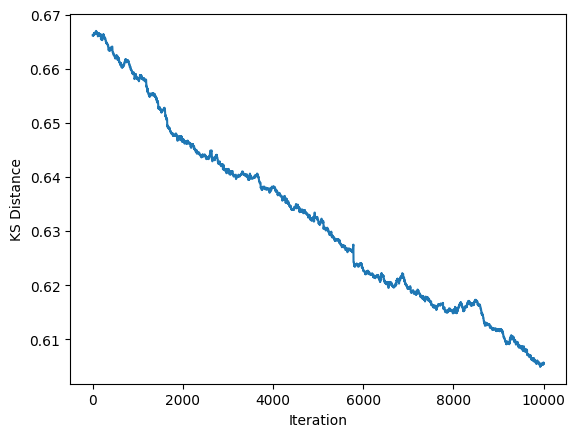

In [39]:
import matplotlib.pyplot as plt

plt.plot(distance_history)
plt.xlabel('Iteration')
plt.ylabel('KS Distance')